**Descrição do projeto**

Os clientes do Beta Bank estão saindo: pouco a pouco, escapulindo todo mês. Os banqueiros descobriram que é mais barato manter os clientes existentes do que atrair novos.

Precisamos prever se um cliente vai deixar o banco em breve. Você tem os dados sobre o comportamento passado dos clientes e rescisões de contratos com o banco.

Construa um modelo com o valor máximo possível de F1. Para passar na revisão, você precisa de um F1-score de pelo menos 0,59 para o conjunto de dados de teste. 

Além disso, meça a métrica AUC-ROC e compare-a com o F1-score.

**Descrição de dados**

Os dados podem ser encontrados no arquivo /datasets/Churn.csv. Faça o download do conjunto de dados.

**Características**

**RowNumber** — índice das strings de dados
**CustomerId** — identificador exclusivo do cliente
**Surname** — sobrenome
**CreditScore** — pontuação de crédito
**Geography** — país de residência
**Gender** — gênero
**Age** — idade
**Tenure** — período de maturação para o depósito fixo de um cliente (anos)
**Balance** — saldo da conta
**NumOfProducts** — número de produtos bancários usados pelo cliente
**HasCrCard** — cliente possui cartão de crédito (1 - sim; 0 - não)
**IsActiveMember** — cliente ativo (1 - sim; 0 - não)
**EstimatedSalary** — salário estimado

**Objetivo**

**Exited** — o cliente saiu (1 - sim; 0 - não)

In [1]:
#1.Baixe e prepare os dados. Certifique-se de explicar a lógica que você segue durante a preparação.

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from scipy import stats
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.metrics import classification_report, confusion_matrix
from imblearn.under_sampling import RandomUnderSampler
from imblearn.pipeline import Pipeline
from sklearn.metrics import accuracy_score
from sklearn.preprocessing import StandardScaler
from sklearn.tree import DecisionTreeClassifier, plot_tree
from imblearn.over_sampling import SMOTE
from sklearn.metrics import roc_auc_score, roc_curve

In [2]:
df_churn = pd.read_csv('Churn.csv')

In [3]:
df_churn

,RowNumber,CustomerId,Surname,CreditScore,Geography,Gender,Age,Tenure,Balance,NumOfProducts,HasCrCard,IsActiveMember,EstimatedSalary,Exited
0,1,15634602,Hargrave,619,France,Female,42,2.0,0.00,1,1,1,101348.88,1
1,2,15647311,Hill,608,Spain,Female,41,1.0,83807.86,1,0,1,112542.58,0
2,3,15619304,Onio,502,France,Female,42,8.0,159660.80,3,1,0,113931.57,1
3,4,15701354,Boni,699,France,Female,39,1.0,0.00,2,0,0,93826.63,0
4,5,15737888,Mitchell,850,Spain,Female,43,2.0,125510.82,1,1,1,79084.10,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
9995,9996,15606229,Obijiaku,771,France,Male,39,5.0,0.00,2,1,0,96270.64,0
9996,9997,15569892,Johnstone,516,France,Male,35,10.0,57369.61,1,1,1,101699.77,0
9997,9998,15584532,Liu,709,France,Female,36,7.0,0.00,1,0,1,42085.58,1
9998,9999,15682355,Sabbatini,772,Germany,Male,42,3.0,75075.31,2,1,0,92888.52,1


In [4]:
#2.Examine o equilíbrio das classes. Treine o modelo sem levar em conta o desequilíbrio. Descreva brevemente suas descobertas.

churn_counts = df_churn['Exited'].value_counts()
print(churn_counts)

churn_percentage = df_churn['Exited'].value_counts(normalize=True) * 100
print("\nClass Distribution (Percentage):")
print(churn_percentage)  #Examinando as classes

Exited
0    7963
1    2037
Name: count, dtype: int64

Class Distribution (Percentage):
Exited
0    79.63
1    20.37
Name: proportion, dtype: float64


In [5]:
df_churn['Tenure'].fillna(df_churn['Tenure'].median(), inplace=True)
print("\nVerificando valores nulos após imputação de 'Tenure':")
print(df_churn.isna().sum())


Verificando valores nulos após imputação de 'Tenure':
RowNumber          0
CustomerId         0
Surname            0
CreditScore        0
Geography          0
Gender             0
Age                0
Tenure             0
Balance            0
NumOfProducts      0
HasCrCard          0
IsActiveMember     0
EstimatedSalary    0
Exited             0
dtype: int64


C:\Users\Usuário\AppData\Local\Temp\ipykernel_4144\3005050009.py:1: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  df_churn['Tenure'].fillna(df_churn['Tenure'].median(), inplace=True)


C:\Users\Usuário\AppData\Local\Temp\ipykernel_4144\876380522.py:8: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x='Exited', y='Percentage', data=plot_df, palette='flare')


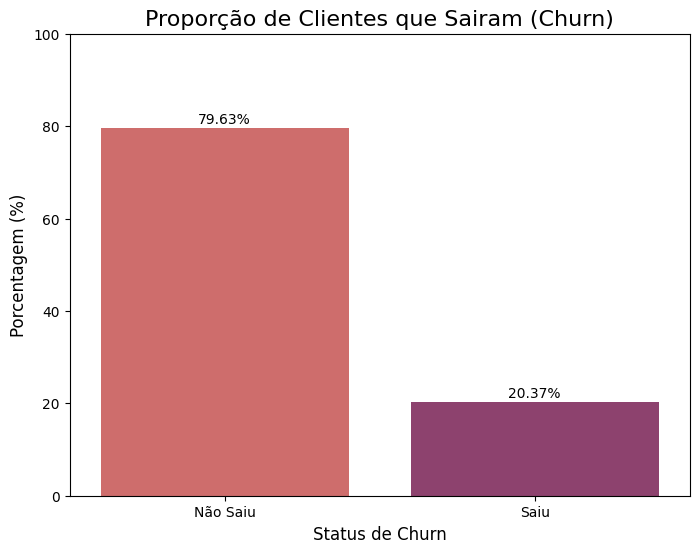

In [6]:
#Análise de proporção

plot_df = churn_percentage.reset_index()
plot_df.columns = ['Exited', 'Percentage']
plot_df['Exited'] = plot_df['Exited'].map({0: 'Não Saiu', 1: 'Saiu'})
plot_df = plot_df.sort_values(by='Percentage', ascending=False)
plt.figure(figsize=(8, 6))
sns.barplot(x='Exited', y='Percentage', data=plot_df, palette='flare')
plt.title('Proporção de Clientes que Sairam (Churn)', fontsize=16)
plt.xlabel('Status de Churn', fontsize=12)
plt.ylabel('Porcentagem (%)', fontsize=12)
plt.ylim(0, 100) 

for index, row in plot_df.iterrows():
    plt.text(index, row.Percentage + 1, f'{row.Percentage:.2f}%', color='black', ha="center", fontsize=10)
plt.show()

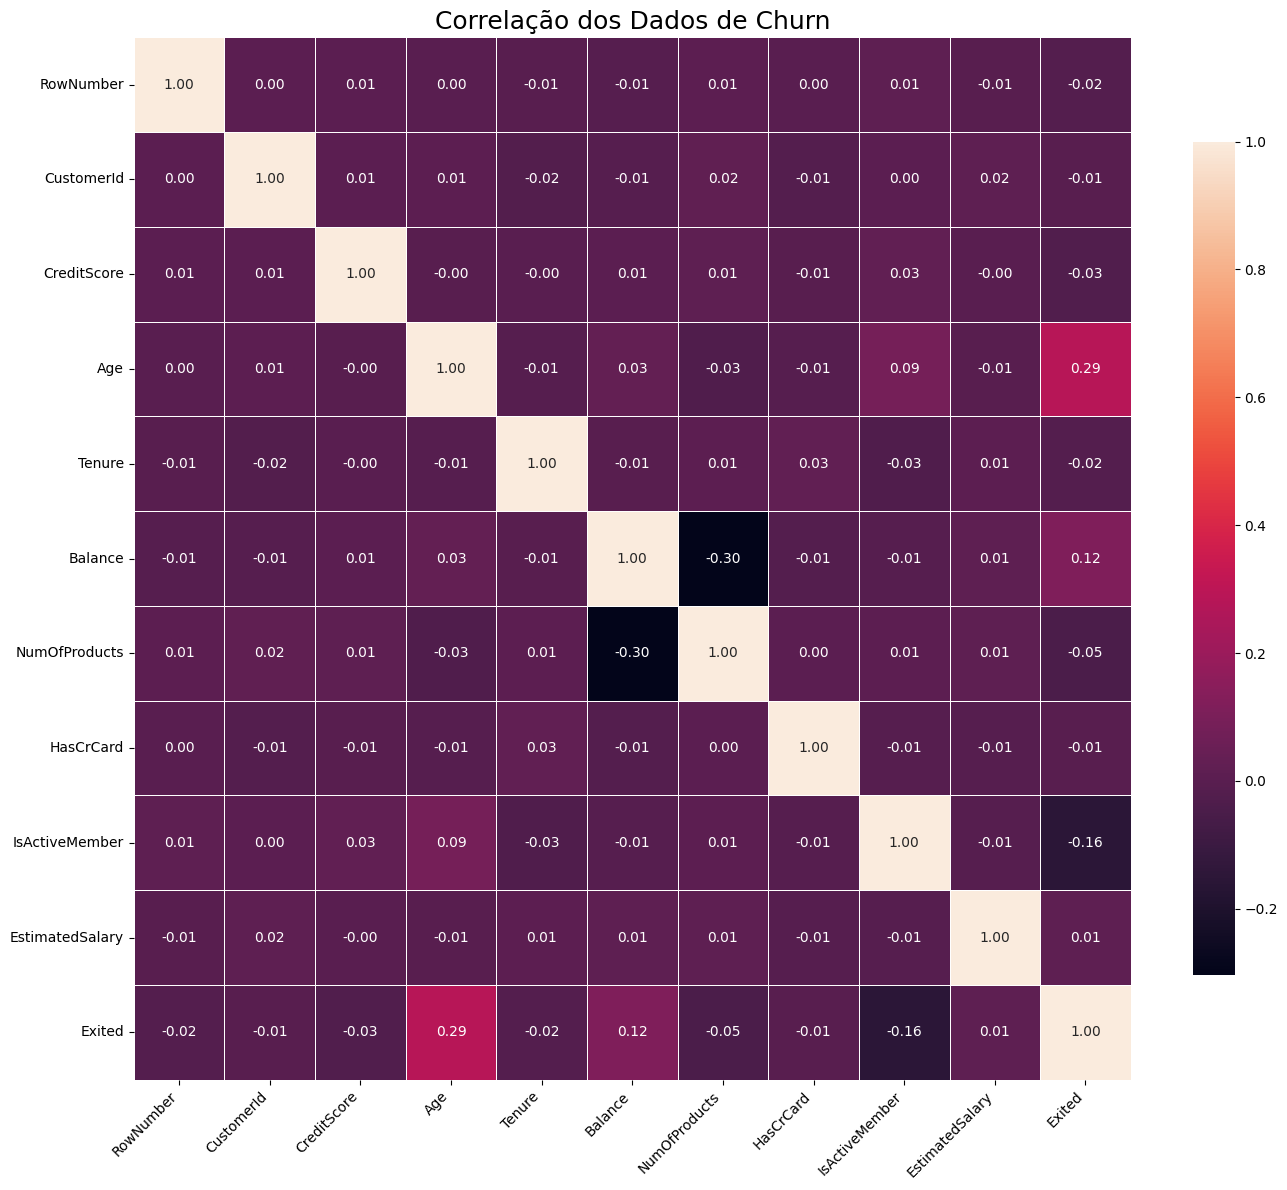

In [7]:
#Correlação Heatmap

correlation_matrix = df_churn.corr(numeric_only=True)

plt.figure(figsize=(14, 12)) 
sns.heatmap(correlation_matrix, annot=True, cmap='rocket', fmt=".2f", linewidths=.5, cbar_kws={'shrink': .8})
plt.title('Correlação dos Dados de Churn', fontsize=18)
plt.xticks(rotation=45, ha='right', fontsize=10)
plt.yticks(rotation=0, fontsize=10)
plt.tight_layout() 
plt.show()

**Conclusão**
A principal conclusão da análise da matriz de correlação é que as variáveis "Age" (Idade), "IsActiveMember" (Membro Ativo) e "NumOfProducts" (Número de Produtos) são as que apresentam as correlações mais notáveis com a variável "Exited" (Churn), que representa a saída do cliente.
Idade (Age): Quanto mais velho o cliente, maior a probabilidade de churn. (Correlação positiva de 0.29)
Membro Ativo (IsActiveMember): Clientes ativos têm menor probabilidade de churn. (Correlação negativa de -0.16)
Número de Produtos (NumOfProducts): Clientes com mais produtos têm uma probabilidade ligeiramente maior de churn. (Correlação positiva de 0.12)

In [8]:
X = df_churn.drop(['Exited', 'RowNumber', 'CustomerId', 'Surname'],  axis=1)
y = df_churn['Exited']

X = pd.get_dummies(X, columns=['Geography', 'Gender'])
X.head()

,CreditScore,Age,Tenure,Balance,NumOfProducts,HasCrCard,IsActiveMember,EstimatedSalary,Geography_France,Geography_Germany,Geography_Spain,Gender_Female,Gender_Male
0,619,42,2.0,0.00,1,1,1,101348.88,True,False,False,True,False
1,608,41,1.0,83807.86,1,0,1,112542.58,False,False,True,True,False
2,502,42,8.0,159660.80,3,1,0,113931.57,True,False,False,True,False
3,699,39,1.0,0.00,2,0,0,93826.63,True,False,False,True,False
4,850,43,2.0,125510.82,1,1,1,79084.10,False,False,True,True,False


In [9]:
#Treinando o modelo

X_train, X_temp, y_train, y_temp = train_test_split(X, y, test_size=0.4, random_state=12345)
X_valid, X_test, y_valid, y_test = train_test_split(X_temp, y_temp, test_size=0.5, random_state=12345)

for depth in range(1, 11): # Test max_depth from 1 to 10
    model = DecisionTreeClassifier(random_state=12345, max_depth=depth)
    model.fit(X_train, y_train) # Train on the training set
    predictions = model.predict(X_valid) # Make predictions on the validation set
    accuracy = accuracy_score(y_valid, predictions) # Evaluate with accuracy

    print(f"Max Depth: {depth}, Validation Accuracy: {accuracy:.4f}")

Max Depth: 1, Validation Accuracy: 0.7910
Max Depth: 2, Validation Accuracy: 0.8240
Max Depth: 3, Validation Accuracy: 0.8380
Max Depth: 4, Validation Accuracy: 0.8520
Max Depth: 5, Validation Accuracy: 0.8530
Max Depth: 6, Validation Accuracy: 0.8580
Max Depth: 7, Validation Accuracy: 0.8500
Max Depth: 8, Validation Accuracy: 0.8475
Max Depth: 9, Validation Accuracy: 0.8470
Max Depth: 10, Validation Accuracy: 0.8395


In [10]:
#A melhor acurácia 'max_depth(6)'
final_model = DecisionTreeClassifier(random_state=12345, max_depth=6)
final_model.fit(pd.concat([X_train, X_valid]), pd.concat([y_train, y_valid]))

test_predictions = final_model.predict(X_test)
test_accuracy = accuracy_score(y_test, test_predictions)
print(f"Test Accuracy with max_depth={depth}: {test_accuracy:.4f}")

print(confusion_matrix(y_test, test_predictions))
print(classification_report(y_test, test_predictions))

Test Accuracy with max_depth=10: 0.8470
[[1517   60]
 [ 246  177]]
              precision    recall  f1-score   support

           0       0.86      0.96      0.91      1577
           1       0.75      0.42      0.54       423

    accuracy                           0.85      2000
   macro avg       0.80      0.69      0.72      2000
weighted avg       0.84      0.85      0.83      2000



In [11]:
smote = SMOTE(random_state=12345)
X_bal, y_bal = smote.fit_resample(X, y)
print(y_bal.value_counts(normalize=False))
print(y.value_counts(normalize=False))

Exited
1    7963
0    7963
Name: count, dtype: int64
Exited
0    7963
1    2037
Name: count, dtype: int64


In [12]:
X_train_bal, X_temp, y_train_bal, y_temp = train_test_split(X_bal, y_bal, test_size=0.4, random_state=12345)
X_valid, X_test, y_valid, y_test = train_test_split(X_temp, y_temp, test_size=0.5, random_state=12345)

In [13]:
#3.Melhore a qualidade do modelo. Certifique-se de usar pelo menos duas abordagens para corrigir o desequilíbrio de classe. Use conjuntos de treinamento e validação para encontrar o melhor modelo e o melhor conjunto de parâmetros. Descreva brevemente suas descobertas.

#Balanceado

param_grid = {
    'max_depth': range(3, 11),
    'min_samples_split': [2, 5, 10],
    'min_samples_leaf': [1, 2, 4]
}

grid = GridSearchCV(
    DecisionTreeClassifier(random_state=12345),
    param_grid,
    cv=5,
    scoring='accuracy'
)
grid.fit(X_train_bal, y_train_bal)

print("Melhores parâmetros:", grid.best_params_)
print("Melhor acurácia média (validação cruzada):", grid.best_score_)

Melhores parâmetros: {'max_depth': 9, 'min_samples_leaf': 1, 'min_samples_split': 5}
Melhor acurácia média (validação cruzada): 0.8507587650444794


In [14]:
#NÃO Balanceado

param_grid = {
    'max_depth': range(3, 11),
    'min_samples_split': [2, 5, 10],
    'min_samples_leaf': [1, 2, 4]
}

grid = GridSearchCV(
    DecisionTreeClassifier(random_state=12345),
    param_grid,
    cv=5,
    scoring='accuracy'
)
grid.fit(X_train, y_train)

print("Melhores parâmetros:", grid.best_params_)
print("Melhor acurácia média (validação cruzada):", grid.best_score_)

Melhores parâmetros: {'max_depth': 7, 'min_samples_leaf': 1, 'min_samples_split': 5}
Melhor acurácia média (validação cruzada): 0.8613333333333333


In [15]:
rf = RandomForestClassifier(random_state=12345, n_estimators=100, max_depth=depth)
rf.fit(X_train_bal, y_train_bal)
print("Acurácia RF (validação):", accuracy_score(y_valid, rf.predict(X_valid)))

print(classification_report(y_valid, model.predict(X_valid)))

Acurácia RF (validação): 0.8791208791208791
              precision    recall  f1-score   support

           0       0.66      0.96      0.78      1583
           1       0.92      0.51      0.66      1602

    accuracy                           0.74      3185
   macro avg       0.79      0.74      0.72      3185
weighted avg       0.79      0.74      0.72      3185



In [16]:
def random_undersample(X, y, random_state=None):
    """
    Realiza Random Undersampling para balancear as classes da variável alvo y.
    
    Parâmetros:
    -----------
    X : pandas.DataFrame ou numpy.ndarray
        Conjunto de dados com as features (variáveis independentes).
        
    y : pandas.Series ou numpy.ndarray
        Vetor com os rótulos (variável dependente / alvo).
        
    random_state : int, opcional
        Semente para reprodutibilidade dos resultados.

    Retorna:
    --------
    X_resampled : pandas.DataFrame
        Conjunto de features balanceado.
        
    y_resampled : pandas.Series
        Vetor de rótulos balanceado.
    """
    
    if isinstance(X, np.ndarray):
        X = pd.DataFrame(X)
    if isinstance(y, np.ndarray):
        y = pd.Series(y)
    
    np.random.seed(random_state)

    # Contar os exemplos de cada classe
    class_counts = y.value_counts()
    min_class = class_counts.idxmin()
    min_count = class_counts.min()

    # Coletar os índices da classe minoritária
    indices_to_keep = y[y == min_class].index.tolist()

    # Para as outras classes, fazer undersampling
    for cls in class_counts.index:
        if cls != min_class:
            cls_indices = y[y == cls].index.tolist()
            sampled_indices = np.random.choice(cls_indices, min_count, replace=False)
            indices_to_keep.extend(sampled_indices)

    # Embaralhar os índices selecionados
    np.random.shuffle(indices_to_keep)

    # Retornar os dados balanceados
    X_resampled = X.loc[indices_to_keep].reset_index(drop=True)
    y_resampled = y.loc[indices_to_keep].reset_index(drop=True)

    return X_resampled, y_resampled

print("Original class distribution:")
print(y.value_counts())

X_res, y_res = random_undersample(X, y, random_state=42)

print("\nResampled class distribution:")
print(y_res.value_counts())

Original class distribution:
Exited
0    7963
1    2037
Name: count, dtype: int64

Resampled class distribution:
Exited
1    2037
0    2037
Name: count, dtype: int64


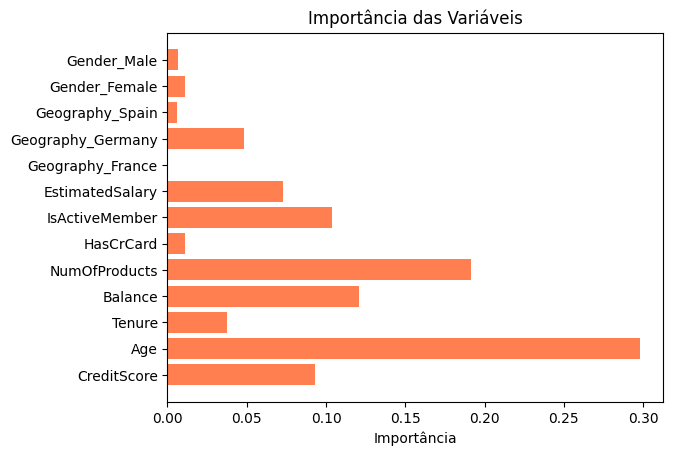

In [17]:
importances = model.feature_importances_
features = X.columns
plt.barh(features, importances, color='coral')
plt.xlabel("Importância")
plt.title("Importância das Variáveis")
plt.show()

In [18]:
#4.Realize o teste final.

best_depth = 4  #Valor encontrado acima

# Unindo os dados de treino e validação(Balanceado)
X_final_train = pd.concat([X_train_bal, X_valid])
y_final_train = pd.concat([y_train_bal, y_valid])

final_model = DecisionTreeClassifier(random_state=12345, max_depth=9, min_samples_leaf=2, min_samples_split=10)
final_model.fit(X_final_train, y_final_train)

y_pred_test = final_model.predict(X_test)
test_accuracy = accuracy_score(y_test, y_pred_test)

print(f"Acurácia no conjunto de TESTE: {test_accuracy:.4f}")
print("\nMatriz de Confusão:")
print(confusion_matrix(y_test, y_pred_test))

print("\nRelatório de Classificação:")
print(classification_report(y_test, y_pred_test)) #F1 Score

Acurácia no conjunto de TESTE: 0.8481

Matriz de Confusão:
[[1377  203]
 [ 281 1325]]

Relatório de Classificação:
              precision    recall  f1-score   support

           0       0.83      0.87      0.85      1580
           1       0.87      0.83      0.85      1606

    accuracy                           0.85      3186
   macro avg       0.85      0.85      0.85      3186
weighted avg       0.85      0.85      0.85      3186



AUC-ROC no conjunto de TESTE: 0.9191


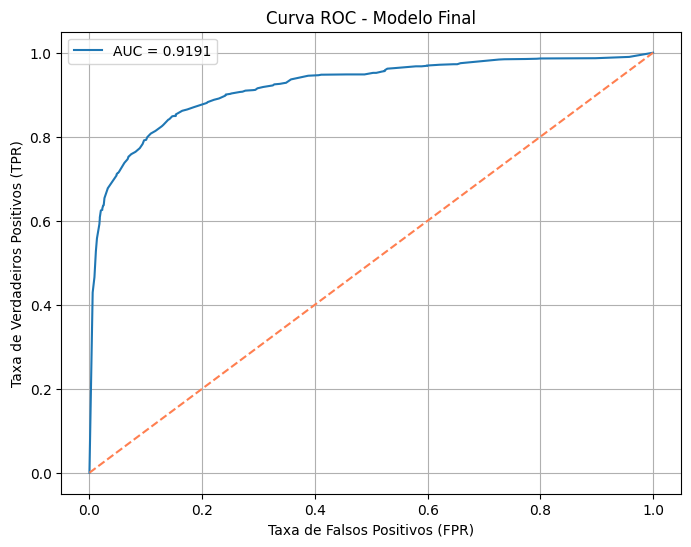

In [19]:
#Métrica AUC-ROC

#Obter as probabilidades do modelo no conjunto de teste
y_proba_test = final_model.predict_proba(X_test)[:, 1]  # Probabilidade da classe '1' (churn)

#Calcular a pontuação AUC-ROC
auc_score = roc_auc_score(y_test, y_proba_test)
print(f"AUC-ROC no conjunto de TESTE: {auc_score:.4f}")

#Gerar pontos para a curva ROC
fpr, tpr, thresholds = roc_curve(y_test, y_proba_test)

#Plotar curva ROC
plt.figure(figsize=(8, 6))
plt.plot(fpr, tpr, label=f'AUC = {auc_score:.4f}')
plt.plot([0, 1], [0, 1], linestyle='--', color='coral')  #Linha aleatória
plt.xlabel('Taxa de Falsos Positivos (FPR)')
plt.ylabel('Taxa de Verdadeiros Positivos (TPR)')
plt.title('Curva ROC - Modelo Final')
plt.legend()
plt.grid(True)
plt.show()

In [20]:
best_depth = 4  #Valor encontrado acima

# Unindo os dados de treino e validação(NÃO Balanceado)
X_final_train = pd.concat([X_train, X_valid])
y_final_train = pd.concat([y_train, y_valid])

final_model = DecisionTreeClassifier(random_state=12345, max_depth=7, min_samples_leaf=1, min_samples_split=5)
final_model.fit(X_final_train, y_final_train)

y_pred_test = final_model.predict(X_test)
test_accuracy = accuracy_score(y_test, y_pred_test)

print(f"Acurácia no conjunto de TESTE: {test_accuracy:.4f}")
print("\nMatriz de Confusão:")
print(confusion_matrix(y_test, y_pred_test))

print("\nRelatório de Classificação:")
print(classification_report(y_test, y_pred_test)) #F1 Score

Acurácia no conjunto de TESTE: 0.8070

Matriz de Confusão:
[[1486   94]
 [ 521 1085]]

Relatório de Classificação:
              precision    recall  f1-score   support

           0       0.74      0.94      0.83      1580
           1       0.92      0.68      0.78      1606

    accuracy                           0.81      3186
   macro avg       0.83      0.81      0.80      3186
weighted avg       0.83      0.81      0.80      3186



AUC-ROC no conjunto de TESTE: 0.9016


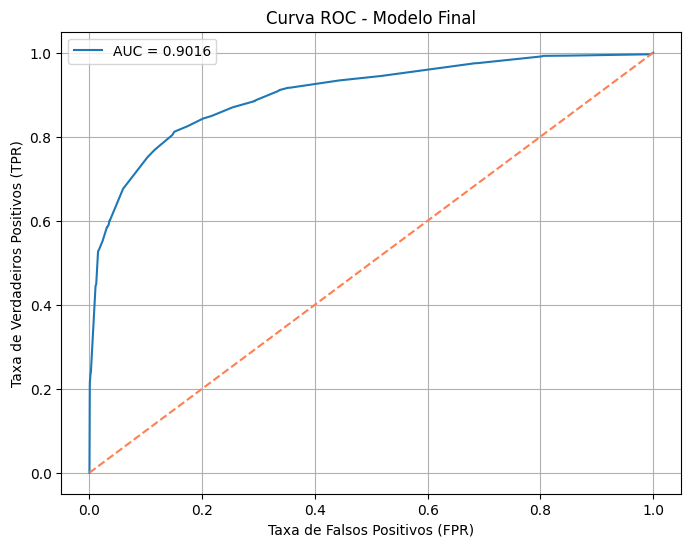

In [21]:
#Métrica AUC-ROC

#Obter as probabilidades do modelo no conjunto de teste
y_proba_test = final_model.predict_proba(X_test)[:, 1]  # Probabilidade da classe '1' (churn)

#Calcular a pontuação AUC-ROC
auc_score = roc_auc_score(y_test, y_proba_test)
print(f"AUC-ROC no conjunto de TESTE: {auc_score:.4f}")

#Gerar pontos para a curva ROC
fpr, tpr, thresholds = roc_curve(y_test, y_proba_test)

#Plotar curva ROC
plt.figure(figsize=(8, 6))
plt.plot(fpr, tpr, label=f'AUC = {auc_score:.4f}')
plt.plot([0, 1], [0, 1], linestyle='--', color='coral')  #Linha aleatória
plt.xlabel('Taxa de Falsos Positivos (FPR)')
plt.ylabel('Taxa de Verdadeiros Positivos (TPR)')
plt.title('Curva ROC - Modelo Final')
plt.legend()
plt.grid(True)
plt.show()

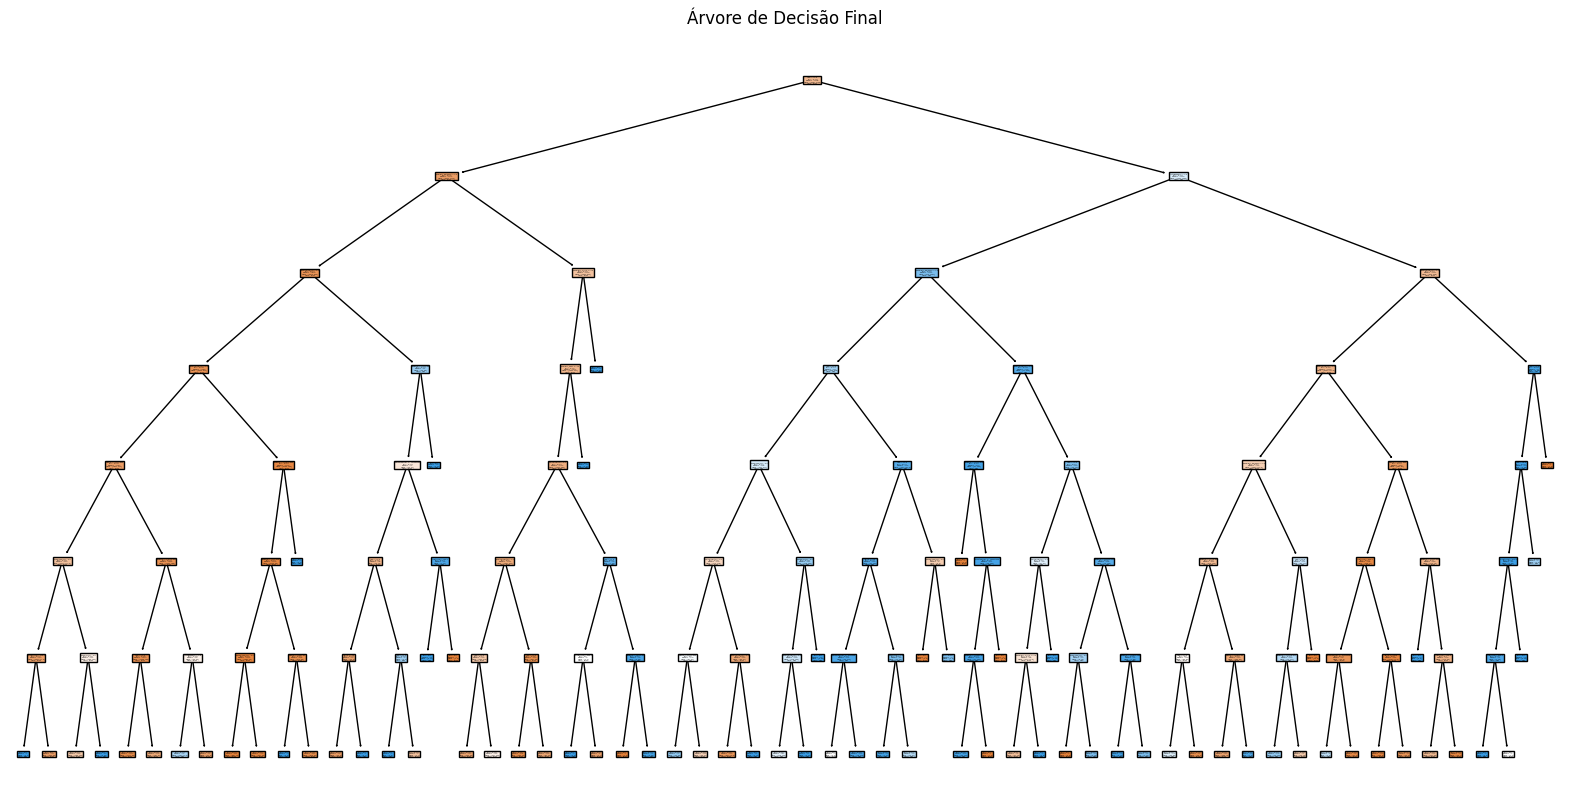

In [22]:
#Árvore

plt.figure(figsize=(20, 10))
plot_tree(final_model, feature_names=X.columns, class_names=['Ficou', 'Saiu'], filled=True)
plt.title("Árvore de Decisão Final")
plt.show()

**Conclusão**

Com base nos dados fornecidos e nas análises de otimização de modelo e tratamento de desequilíbrio de classes.
A decisão final sobre qual dos modelos (com class_weight ou com undersampling) é o "melhor" deve ser baseada em uma análise cuidadosa das métricas de avaliação, especialmente o F1-score e o recall da classe minoritária, e nas curvas ROC e Precision-Recall (PR).
A Curva ROC e AUC-ROC fornecem uma visão geral da capacidade de discriminação do modelo.
A Curva PR e AUC-PR são frequentemente mais informativas para dados desbalanceados, pois destacam o desempenho do modelo na classe minoritária de forma mais clara, especialmente em termos de precisão e recall.

Nathália Sorg